# Analysis of Heart Rate Variability
by Patrick Cullinane


## Background

#### Dataset

This dataset we are using to analyze Heart Rate Variability (HRV) comes from the SWELL knowledge dataset on stress and user modeling found here: http://cs.ru.nl/~skoldijk/SWELL-KW/Dataset.html. The dataset contains facial recognition and posture analysis, but for the purposes of this analysis we will just dig into the heart variability aspect. 

The big picture in all of this is that HRV is a non-invasive indicator of stress. Specifically, increases in variability are associated with decreased stress an increased health. This goes against the intuitive notion that heart beats are ordered processes, and a more chaotic heart beat appears to be healthier.  

#### What is HRV? 

HRV is a physiological phenomenom in which the time period between heart beats has been shown to vary. To obtain HRV the interval between the "R" waves in the QRS complex are measured between successive heartbeats. As mentioned above there is strong evidence that suggests that increased variability is associated with greater health. Specifically, it has been shown as an indicator of increased emotional stress (http://tinyurl.com/y4x953x4), increase anxiety (http://tinyurl.com/y3fggcah), and possibly an indicator of Post-traumatic stress disorder (PTSD) (https://www.biologicalpsychiatryjournal.com/article/S0006-3223(97)00475-7/fulltext). 

It is important to note that RMSSD is relative to each individual based on age, fitness, unique physiology, and other factors. When HRV "decreases" what is meant is the variation in periods between heartbeats becomes less chaotic, we would therefore see a decrease RMSSD number as a result.

## Procedure

In the SWELL dataset study participants did not smoke or drink caffeine 3 hours prior to the experiment. The experiment was divided into three sections each lasting about an hour and each starting with a relaxation (control) phase of about eight minutes. Once the relaxation phase was completed participants were assigned random tasks and told to write reports on them. During each segment participants were given an informational and a opinion report. They then made a presentation on the one of their choosing. The phases consisted of neutral - the participant was told they could work on the task as long as they wanted, stressor: time pressure - time to finish tasks was cut down by 2/3 of the previous time period, stressor: interruptions - 8 emails were sent to the particpants while they performed tasks, and some of them required replies while others didn't. The participants were instructed that it was important to finish the tasks in order to obtain the full particpation fee, which helped to set real world expectations. The participants were students comprised of 17 males and 8 females. Various measurements were obtained, but for the purposes of this dataset we will focus on the ECG data  which provides the heart rate and heart rate variability measurements. 

Multiple measurements were taken but for the purposes of this analysis we will focus on the root mean square of successive differences (RMSSD) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943000/. 

## 3. Hypothesis

Overall the hypothesis in the study is that HRV as measured by mean RMSSD will decrease (variability will go down) when a stress, in the form of time compression or interruption, is introduced. The null hypothesis will be that the mean RMSSD during each condition will be the same as the control (rest) period.

In [1]:
#import necessary libraries

import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
import seaborn as sns
import networkx as nx
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import matplotlib.patches as mpatches
%matplotlib inline

## Pre-processing

To get the data ready we need to load it from a file in the directory. The data is organized by participant in sheets in the excel spreadsheet. After loading the data we will unpack all the sheets and make them into one large dataframe.

In [2]:
files = glob.glob(os.path.join(os.getcwd(),'data') + '/*.xlsx') #find all files with .csv
files

['/Users/patrickcullinane/Documents/Code/hrv_analysis/data/hrv stress labels.xlsx']

In [3]:
data = pd.ExcelFile(files[0]); data

The raw data is stored in an Excel sheet with each particpants data on a separate tab. To retrieve the data we must iterate through all the sheets in the file and append them to one big dataframe. 

In [4]:
#the data is in sheets - unpack all the sheets and append them in a for loop
for sheet in data.sheet_names:
    if sheet == 'p1':
        data_df = pd.read_excel(files[0], sheet_name=sheet)
        #print('sheet: ' + str(sheet))
    else:
        df = pd.read_excel(files[0], sheet_name=sheet)
        data_df = data_df.append(df, ignore_index=True) 
        if sheet == 'p25':
            print('the data is loaded')
        else:
            pass

the data is loaded


As you can see above there are 25 sheets and below you can see that there are 12 rows. For the purposes of this notebook we will focus on the columns: subject, label, condition, RMSSD, and HR. 

In [5]:
#look at the data
data_df.head()

,Unnamed: 0,PP,C,timestamp,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,0,PP1,1,20120918T131600000,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,1,PP1,1,20120918T131700000,61.0,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,2,PP1,1,20120918T131800000,64.0,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,3,PP1,1,20120918T131900000,60.0,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,4,PP1,1,20120918T132000000,61.0,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


Just to double check we see that there are 25 particpants in the dataset by finding all the unique values in the subject row.

In [6]:
#there are 25 subjects in the dataset
data_df.subject.unique()

array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11',
       'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20',
       'p21', 'p22', 'p23', 'p24', 'p25'], dtype=object)

As you can see below although there are 3,140 rows there are only 1490 HR & RMSSD measurements. This means the the rest of the rows are NA.

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 12 columns):
Unnamed: 0     3140 non-null int64
PP             3140 non-null object
C              3140 non-null int64
timestamp      3140 non-null object
HR             1490 non-null float64
RMSSD          1490 non-null float64
SCL            2578 non-null float64
date           3140 non-null datetime64[ns]
subject        3140 non-null object
label          3140 non-null object
Condition      3140 non-null object
ElapsedTime    3140 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 294.5+ KB


The phase of the study is labeled in the condition column and given a label. Either label can be used interchangeably. 

In [8]:
#print out phase of study
print(data_df.label.unique())
print(data_df.Condition.unique())

['rest' 'no stress' 'time pressure' 'interruption']
['R' 'N' 'T' 'I']


## Data Notes

The important take-aways from exploring the data is that there are 12 columns of data with 3,140 entries, but 1490 RMSSD measurements. For the purposes of testing this hypothesis we are interested in RMSSD, condition, and participant. There are two rows that designate conditions; 'Condition' and 'label'. The condition row is labeled 'R', 'N', 'T', and 'I' corresponding to 'rest', 'no stress', 'time pressure', and 'interruption'.

## Visualize Population Data

Below are the mean heart rates and root mean square of successive differences (RMSSD). This is often used as a good 'snapshot' of autonomic nervous system's parasympathetic branch. In other words RMSSD can be used as a marker for parasympathetic activity/stress on the body. 

To get familiar with the data let's look at how its distributed by condition. Going to start witha pairplot comparing Heart Rate (HR) v. RMSSD.  

As you can see below the distribution in the top right corner shows how similar the distribution of the RMSSD values are for all participants and for all phases of the study. Also it appears that the data is skewed to the right, meaning is does not follow a normal distribution.

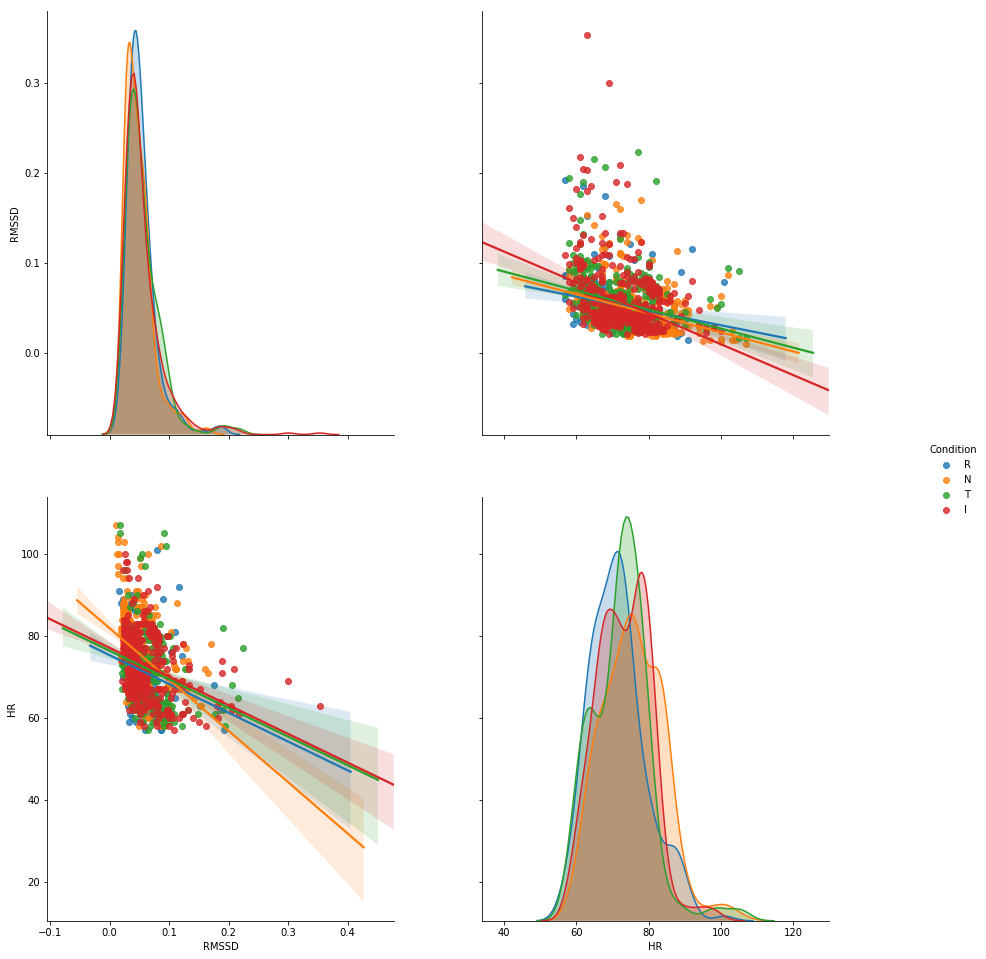

In [10]:
data_pairplot = data_df[['Condition','RMSSD','HR']].dropna()

g=sns.pairplot(data_pairplot, kind='reg', hue='Condition')
g.fig.set_size_inches(15,15)

plt.show()

## Analysis of RMSSD by Condition

The plot above shows all the distributions for each condition. In the below barplots we take the control, 'rest', and compare it against each condition. Again in each condition it looks like our data is skewed to the right.

It appears that the rest condition and each treatment have similar distributions and that the neutral condition show a lower average RMSSD than the other treatment states.

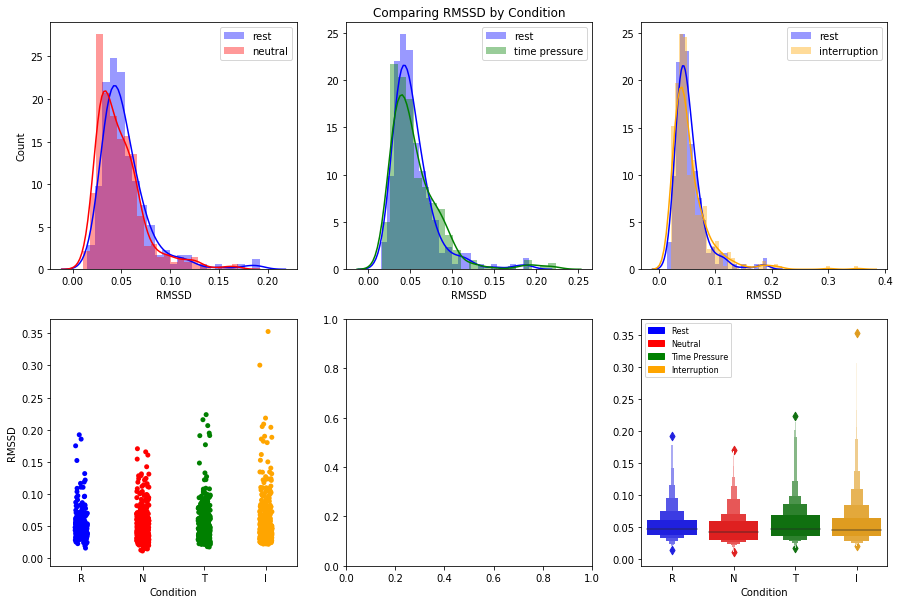

In [13]:
rest = data_df[data_df['Condition']=='R']
neutral = data_df[data_df['Condition']=='N']
time = data_df[data_df['Condition']=='T']
interrupt = data_df[data_df['Condition']=='I']

fig, axr = plt.subplots(nrows=2 ,ncols=3, figsize=(15,10))

sns.distplot(rest['RMSSD'].dropna(),color='blue',ax=axr[0,0],label='rest')
sns.distplot(neutral['RMSSD'].dropna(),color='red',ax=axr[0,0],label='neutral')

sns.distplot(rest['RMSSD'].dropna(),color='blue',ax=axr[0,1],label='rest')
sns.distplot(time['RMSSD'].dropna(),color='green',ax=axr[0,1],label='time pressure')

sns.distplot(rest['RMSSD'].dropna(),color='blue',ax=axr[0,2],label='rest')
sns.distplot(interrupt['RMSSD'].dropna(),color='orange',ax=axr[0,2],label='interruption')

clrs = ['blue','red','green','orange']

#sns.barplot(x=data_df['Condition'], y=data_df['RMSSD'], palette=clrs, ax=axr[1,0])
sns.stripplot(x=data_df['Condition'], y=data_df['RMSSD'], palette=clrs, ax=axr[1,0],label=False)
sns.boxenplot(x=data_df['Condition'], y=data_df['RMSSD'], palette=clrs, ax=axr[1,2])

axr[0][0].legend()
axr[0][1].legend()
axr[0][2].legend()

axr[0][0].set_ylabel('Count')
axr[1][1].set_ylabel('')
axr[1][2].set_ylabel('')
axr[0][1].set_title('Comparing RMSSD by Condition')

rest = mpatches.Patch(color='blue', label='Rest')
neutral = mpatches.Patch(color='red', label='Neutral')
time_pressure = mpatches.Patch(color='green', label='Time Pressure')
interruption = mpatches.Patch(color='orange', label='Interruption')

plt.legend(loc='upper left', prop={'size': 8}, handles=[rest,neutral,time_pressure,interruption])

plt.show()

# RMSSD Ranges By Subject

To go a little more in depth let's visualize how RMSSD differed for each participant in each phase of the study. To do this we will display each participants range of RMSSD values by means of a boxplot for each condition. As you can see below no data was collected for two participants (p8 & p11) and data was not fully collect for 9 other participants. In this case either samples were not collected for 1 or 2 conditions in the 9 participants that do not have complete data.

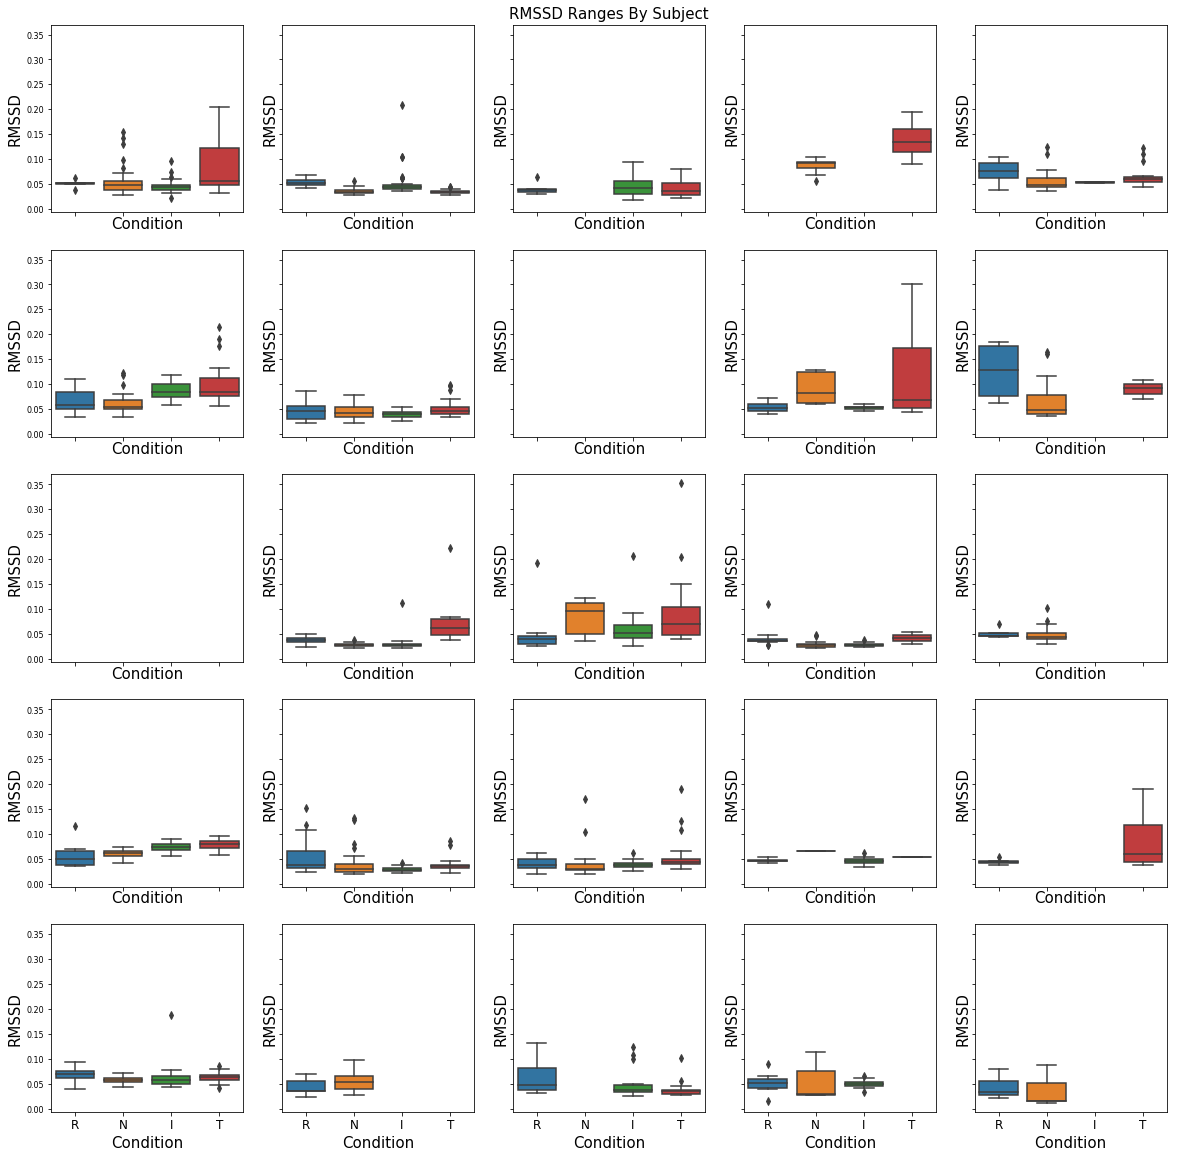

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(20,20))

rows = 5
columns = 5

temp_list = [0,5,10,15,20]

for x in range(rows):
    for y in range(columns):
        value = temp_list[x] + y
        DATA=data_df[data_df['subject']==list(rmssd_means.keys())[value]]
        sns.boxplot(x='Condition',y='RMSSD',data=DATA,ax=axs[x,y])

axs[0][2].set_title('RMSSD Ranges By Subject')
plt.show()

# Subject ttest

To find out if any of the treatment conditions affected RMSSD we compare the rest state versus each treatment condition. The ttest will determine if the treament averages are statistically significant. As we evalulate these conditions we will drop all the rows that have NA in them. From the above data exploration we know that data collected on some of the participants was incomplete and two did not have any data collected at all. The null hypothesis as stated above is that there will be no statistical difference between the rest condition and each individual treatment condition. Alpha is set at 0.05, meaning that the p value will have to fall below that threshold in order to reject the null hypothesis.

In [21]:
rest_rmssd_all = data_df[data_df['Condition']=='R'].RMSSD
neutral_rmssd_all = data_df[data_df['Condition']=='N'].RMSSD
time_rmssd_all = data_df[data_df['Condition']=='T'].RMSSD
interrupt_rmssd_all = data_df[data_df['Condition']=='I'].RMSSD

The first condition to be measure is rest v. neutral conditon. In this case alpha is greater than the p-value therefore we reject the null hypothesis.

In [74]:
#compare rest v. neutral
stat, p = ttest_ind(rest_rmssd_all.dropna(), neutral_rmssd_all.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
    print(rest_rmssd_all.dropna().mean())
else:
    print('Different distribution (reject H0)')

Statistics=2.439, p=0.015
Different distribution (reject H0)


In both the time compression and interruption conditions p-value is greater than alpha therefore we fail to reject the null hypothesis.

In [63]:
#compare rest v. time
stat, p = ttest_ind(rest_rmssd_all.dropna(), time_rmssd_all.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=-1.033, p=0.302
Same distribution (fail to reject H0)


In [64]:
#compare rest v. time
stat, p = ttest_ind(rest_rmssd_all.dropna(), interrupt_rmssd_all.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=-0.825, p=0.409
Same distribution (fail to reject H0)


## Log Transformation


As a secondary check we will apply log transformation to the data to see if that makes a difference

In [75]:
rest_rmssd_log = rest_rmssd_all.apply(np.log)
neutral_rmssd_log = neutral_rmssd_all.apply(np.log)
time_rmssd_log = time_rmssd_all.apply(np.log)
interrupt_rmssd_log = interrupt_rmssd_all.apply(np.log)

Again the neutral state p-value is lower than the neutral values and thus we reject H0.

In [81]:
#compare rest v. neutral
stat, p = ttest_ind(rest_rmssd_log.dropna(), neutral_rmssd_log.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=3.274, p=0.001
Different distribution (reject H0)


After applying log transformation to time and interruption sets we still fail to reject H0.

In [78]:
stat, p = ttest_ind(rest_rmssd_log.dropna(), time_rmssd_log.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=-0.564, p=0.573
Same distribution (fail to reject H0)


In [80]:
stat, p = ttest_ind(rest_rmssd_log.dropna(), interrupt_rmssd_log.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=0.130, p=0.896
Same distribution (fail to reject H0)


## Research Proposal

### Abstract

Using the previous experiment we saw that the neutral state provided the only statistically significant difference between a resting state. The mean RMSSD across 25 participants for the neutral state was lower than the mean RMSSD rest state. Because each treatment state was introduced after brief period with the control state it is possible that some of the effects from each state contaminated the data from other states. Each condition was introduced during a three hour window and introduced in the same sequence. Additionally, samples were collected from only a three hour window on the same day. The body may have different reactions to psychological stress during a short window versus a multi-day window. Therefore we would like to test the effect of chronic stress on Heart Rate Variability.

We are interested in if workplace distractions decrease Heart Rate Variability as measured by RMSSD. Overall employee health could possibly lead to better decision making and thus increase value to the company. Tracking RMSSD may lead to a method of quantifying workplace stress and thus provide companies a method evaluating workplace environment and culture's impact on employee's physiological readiness. The next research proposal aims to study the effect of distractions over the course of a workweek. The study will focus on the interruption condition to see if workplace interruptions cause a decrease in RMSSD/HRV.

### Hypothesis

The hypothesis that we will be testing is that email interruptions will cause a change in mean HRV as measured by RMSSD versus a group not facing interrutions over the course of five days. The null hypothesis for this case will be that there is no change in RMSSD between the interrption group and the non-interruption group over that same five days.


### Procedure

The participants in the study will be assigned a task for which they will have to write a report on that task and present their report at the end of the testing period. Overall the study will be conducted over five days and each day will consist of a three hour block where the participants will be measured. Participants will be randomly assigned to the control group or the treatment group. The control group will be told they can complete the assigned task within the time period alloted. In addition to completing the assigned task, the treatment group will be told they need to respond to emails immediately to emails sent during their measurment period. 

The study will be measuring heart rate variability by means of the root mean square of successive differences (RMSSD) using a chest strap heart rate monitor. RMSSD will be taken every minute by monitoring the heart rate continuously and returning the average RMSSD from that period. Data from each group will therefore consist of average RMSSD's taken every minutes during a three hour period for five successive days. The participants will be compenaated for their time. At the beginning of the study they participants will be told the compensation is contigent on their full participation therefore providing a motivating factor to complete the assigned task similar to a workplace environment.

### Methods

The baseline for this study has been established at +/-5% and we will be looking for a +/-12% change against control. The sample size will need to be 21,000 to achieve this, and with 25 participants this will mean that we need >170 samples/day for five days. If we take a sample every minute for three hours over five days this will give use 22,500 samples and thus satisfy our sample size requirements. The test will be two-sided as we are looking for a change in HRV in either direction.

The mean interruption RMSSD will be compared to the mean control RMSSD using a ttest to see if the differences are statistically significant. Alpha for the study will be 0.05 and power will be 80%. 

We don't anticipate this study will cause any adverse effects on the participants health but if we do noticed RMSSD drop-off below 20% we will stop to the study to evaluate the accumulated stress on the participants. If HRV as measured by RMSSD increases signficantly no action will be taken.